# Assignment 4: Clustering

In this assignment we'll be looking at three popular types of clustering algorithms -- K-Means clustering, Density Based clustering, and Hierarchical clustering. We'll also look at some measures of cluster quality like cohesion, separation and silhoutte coefficient.

## Part 1: Implement K Means Clustering

In k-means clustering you are given a dataset and a hyperparameter, k, specifying the number of desired clusters. The objective function of k-means is to minimize the sum of squared error (SSE) of the output clusters. Unfortunately, the solution to this problem is NP Hard. In this assignment we'll be implementing the iterative algorithm that produces the locally optimal solution to this problem but guarantees convergence.

In [1]:
# Some headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from numpy.random import rand, random
from numpy import square, sqrt
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold

In [3]:
# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

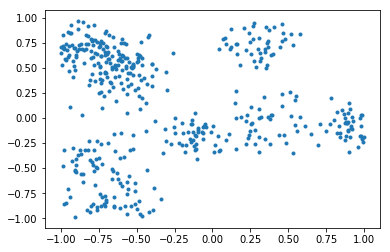

In [4]:
# get data from text file
data = np.genfromtxt("data_kmeans.csv", delimiter=",")
plt.scatter(data[:,0],data[:,1], marker='.')

Q1. Implement the function `generateClusters` that returns clusters, given the cluster centroids (`mu`) and the dataset (`data`). Each datapoint needs to be associated to the closest cluster centroid.

In [5]:
def generateClusters(data, mu):
    # your code goes here
    clusters = []
    minDistance = 100000
    counter = 0
    minCentroid = 0
    
    # Initialize empty array clusters
    for i in range(0,len(mu)):
        clusters.append([])
    # Fill clusters  
    for dataPoint in data:
        for centroid in mu:
            distance = sqrt(square(dataPoint[0]-centroid[0]) + square(dataPoint[1]-centroid[1]))
            if distance < minDistance:
                minDistance = distance
                minCentroid = counter
            counter = counter + 1
        clusters[minCentroid].append(dataPoint)
        counter = 0
        minCentroid = 0
        minDistance = 100000
    return np.asarray(clusters)

Q2. Implement the function `recomputeCentroids` that returns the centroids given a set of input clusters. Hint: you need to calculate the mean for each cluster.

In [6]:
def recomputeCentroids(clusters):
    # your code goes here
    centroids = []
    for cluster in clusters:
        if cluster == []:
            centroids.append(np.asarray([0,0]))
        else:
            centroids.append(np.nanmean(cluster, axis=0))
    return np.asarray(centroids, dtype=object)

Q3. Implement the function `checkConvergence` that checks if the termination condition of k means algorithm has reached, i.e. the previous centroids are the same as the new centroids. 

In [7]:
def checkConvergence(mu, previous_mu):
    # your code goes here
    return np.array_equal(mu,previous_mu)

Q4. Implement the function `kMeansClustering` that returns k clusters along with their centroids given the input dataset and the desired number of clusters (`k`).

In [8]:
def kMeansClustering(data, k):
    clusters = None
    mu = None
    # your code goes here
    
    #Initialize random mu
    mu = np.random.rand(k,2)
    previous_mu = [0,0]
    
    for i in range(0,k):
        if checkConvergence(mu,previous_mu) == False:
            clusters = generateClusters(data,mu)
            previous_mu = mu
            mu = recomputeCentroids(clusters)  
        else: 
            return(mu, clusters)
    return(mu, clusters)

Q5. Cluster the data using `kMeansClustering` with `k = 5`. Display the clusters using `plt.scatter`, make sure to mark different clusters with a different color. Also calculate the cohesion and separation for the resulting clustering.

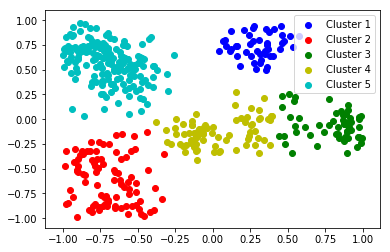

In [79]:
# your code goes here
mu,clusters = kMeansClustering(data,5)
clusterOne = np.asarray(clusters[0])
clusterTwo = np.asarray(clusters[1])
clusterThree = np.asarray(clusters[2])
clusterFour = np.asarray(clusters[3])
clusterFive = np.asarray(clusters[4])
plt.scatter(clusterOne[:,0],clusterOne[:,1],c='b',label='Cluster 1')
plt.scatter(clusterTwo[:,0],clusterTwo[:,1],c='r',label='Cluster 2')
plt.scatter(clusterThree[:,0],clusterThree[:,1],c='g',label='Cluster 3')
plt.scatter(clusterFour[:,0],clusterFour[:,1],c='y',label='Cluster 4')
plt.scatter(clusterFive[:,0],clusterFive[:,1],c='c',label='Cluster 5')
plt.legend()
plt.show()

Q6. Find the best k for this dataset by plotting SSE vs k for k = 1-10. Based on your plot, which value of k would you choose and why?

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """


<function matplotlib.pyplot.show(*args, **kw)>

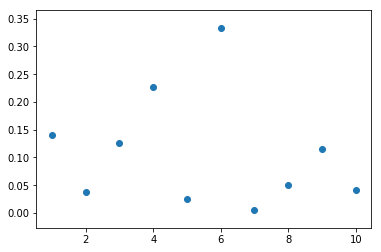

In [13]:
# your code goes here
k = 1
maxK = 10
sse = 0
sseK = []
while k<=maxK:
    mu, clusters = kMeansClustering(data,k)
    for i in range(0,len(mu)):
        for point in clusters[i]:
            sse = square(point[0]-mu[i][0]) + square(point[1]-mu[i][1])
    sseK.append(sse)
    sse = 0
    k = k + 1

plt.scatter(range(1, 11),sseK)
plt.show
# I will choose k equals to 7, since the purpose is to increase cohesion while minimizaing
# the distance between the points to its cluster showing more related items 

## Part 2: Implement DBSCAN

For this part you'll be implementing DBSCAN, one of the most popular density based clustering algorithms.

<class 'numpy.ndarray'>


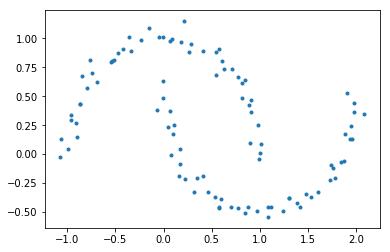

In [2]:
# get data from text file
data = np.genfromtxt("data_dbscan.csv", delimiter=",")
plt.scatter(data[:,0],data[:,1], marker='.')
print(type(data))

Q8. First, run your `kMeansClustering` with `k = 2` on this dataset and display the output clusters (make sure that different clusters are marked with different colors). What do you observe? (Answer as a comment.)

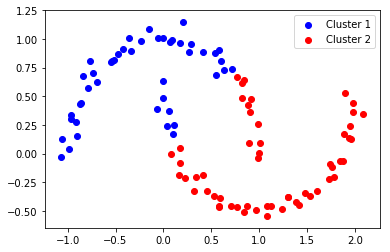

In [82]:
# your code goes here
mu,clusters = kMeansClustering(data,2)
clusterOne = np.asarray(clusters[0])
clusterTwo = np.asarray(clusters[1])
plt.scatter(clusterOne[:,0],clusterOne[:,1],c='b',label='Cluster 1')
plt.scatter(clusterTwo[:,0],clusterTwo[:,1],c='r',label='Cluster 2')
plt.legend()
plt.show()
# Observations
# It is a non-globular shape and K-means is limited to set clusters
# in a spherical way, so the interpretation of the data looses meaning

Q9. Implement the DBSCAN algorithm and display output clusters. There is a  pseudocode version of the DBSCAN algorithm on [Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) that you are welcome to follow.

Run your DBSCAN clustering on the data with eps = 0.28 and minPts = 8. Plot the resulting clusters with each cluster, and noise, indicated by different colors. 

In [3]:
class DataPoint:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = 0

In [4]:
def neighbors(dataPoints, actualPoint, eps):
    neighbor = []
    for i in range(0,len(dataPoints)):
        distance = sqrt(square(dataPoints[i].x-actualPoint.x) + square(dataPoints[i].y-actualPoint.y))
        if distance <= eps:
            neighbor.append(i)
    return neighbor

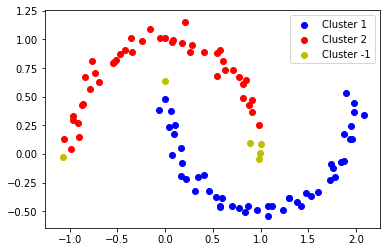

In [7]:
# your code goes here
numClusters = 0
dataPoints = []
eps = 0.28
minPts = 8

for dataPoint in data:
    dataPoints.append(DataPoint(dataPoint[0],dataPoint[1],0))

for x in range(0,len(dataPoints)):
    if dataPoints[x].label != 0:
        continue
    neighbor = neighbors(dataPoints, dataPoints[x], eps)
    if len(neighbor) < minPts:
        dataPoints[x].label = -1
    else:
        numClusters = numClusters + 1
        dataPoints[x].label = numClusters
        i = 0
        while i < len(neighbor):
            j = neighbor[i]
            if dataPoints[j].label == -1:
                dataPoints[j].label = numClusters
            elif dataPoints[j].label == 0:
                dataPoints[j].label = numClusters
                newNeighbor = neighbors(dataPoints, dataPoints[j], eps)
                if len(newNeighbor) >= minPts:
                    neighbor = neighbor + newNeighbor
            i = i + 1

clusterOneX = []
clusterOneY = []
clusterTwoX = []
clusterTwoY = []
clusterOutliersX = []
clusterOutliersY = []
for dataPoint in dataPoints:
    if dataPoint.label == 1:
        clusterOneX.append(dataPoint.x)
        clusterOneY.append(dataPoint.y)
    elif dataPoint.label == 2:
        clusterTwoX.append(dataPoint.x)
        clusterTwoY.append(dataPoint.y)
    else:
        clusterOutliersX.append(dataPoint.x)
        clusterOutliersY.append(dataPoint.y)
plt.scatter(clusterOneX,clusterOneY,c='b',label='Cluster 1')
plt.scatter(clusterTwoX,clusterTwoY,c='r',label='Cluster 2')
plt.scatter(clusterOutliersX,clusterOutliersY,c='y',label='Cluster -1')
plt.legend()
plt.show()

## Part 3: Clustering with scikit-learn and scipy

#### Data

For this part of the assigment you'll be working with the Epileptic Seizure Recognition Data Set developed at Rochester Institute of Technology. In this data set each row is a sample of the EEG recording at a different point in time. The dataset contains 179 columns, the first 178 are the EEG features while the last column represents the label y {1, 2, 3, 4, 5}. All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have an epileptic seizure. The class labels will not be used for clustering (which is an *unsupervised* task!) - they will just be used for plotting the data. The only change that was made to the original dataset was removing the first column, which contained the row indexes. You can find additional information about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition).

In [2]:
# Reading the Epileptic Seizure Data Set
dataset = pd.read_csv("data_seizure_edited.csv", header = 0)
print(dataset.shape)

#split the dataset into features and labels
labels = dataset['y']
raw_data = dataset.drop('y', axis = 1)

dataset.head()

(11500, 179)


X1   X2   X3   X4   X5   X6   X7   X8   X9  X10 ...  X170  X171  X172  \
0  135  190  229  223  192  125   55   -9  -33  -38 ...   -17   -15   -31   
1  386  382  356  331  320  315  307  272  244  232 ...   164   150   146   
2  -32  -39  -47  -37  -32  -36  -57  -73  -85  -94 ...    57    64    48   
3 -105 -101  -96  -92  -89  -95 -102 -100  -87  -79 ...   -82   -81   -80   
4   -9  -65  -98 -102  -78  -48  -16    0  -21  -59 ...     4     2   -12   

   X173  X174  X175  X176  X177  X178  y  
0   -77  -103  -127  -116   -83   -51  4  
1   152   157   156   154   143   129  1  
2    19   -12   -30   -35   -35   -36  5  
3   -77   -85   -77   -72   -69   -65  5  
4   -32   -41   -65   -83   -89   -73  5  

[5 rows x 179 columns]

#### Data scaling & dimensionality reduction with PCA
Both K-means and DBSCAN break down in high dimensions, as distance (and thus density) become less meaningful in high dimensions. So, before we run either of these clustering algorithms, we want to reduce the dimensionality of our dataset. Recall that it is critical to scale your data prior to running PCA. 

Q1. 
* Use `sklearn.preprocessing.StandardScaler` to standardize the dataset’s features (mean = 0 and variance = 1). Only standardize the the features, not the class labels! This will be required for running the principal component analysis (PCA) dimensionality reduction. Note that `StandardScaler` returns a numpy array.
* Use `sklearn.decomposition.PCA` to perform PCA on the data.
* Set `n_components` to 0.95 and `svd_solver` to 'full', so that the PCA will reduce the number of dimensions to however many are necessary to retail 95% of the variance. 
* Use `fit_transform` to perform the dimensionality reduction. 
* Note that `fit_transform` returns a numpy array. Put your transformed data back into a Pandas DataFrame by doing something like this (subsitute your variable names): `data = DataFrame(pca_data)`
* Show the head of the resulting DataFrame (and make sure the dimenaionality has actually been reduced).

In [3]:
# your code goes here
scaler = StandardScaler()
scale_data = scaler.fit_transform(raw_data)
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(scale_data)
data = DataFrame(pca_data)
data.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0         1         2         3         4         5         6   \
0 -0.137475 -1.146419  0.836893 -0.071085 -0.177048 -0.825731  0.777044   
1 -1.703794 -3.643195  6.153822  8.033432  4.549536  5.892971  3.758370   
2  0.495650 -0.261660  0.931210 -0.663789  1.587618 -1.604942 -0.880830   
3 -0.174219  0.249557 -0.073646 -0.108047  1.615415 -3.136337 -0.559638   
4 -0.239163  0.117304  0.486502 -0.530629  0.187739 -0.371186 -0.045861   

         7         8          9     ...           29        30        31  \
0  0.337638  2.744494  -0.734679    ...     0.994987 -2.154933  1.053161   
1 -5.804916  4.187441  11.192247    ...    -5.864539 -7.613729  5.082526   
2 -1.591959 -0.400873  -1.435073    ...     0.124686  0.027333  0.946955   
3 -3.032901 -0.222729  -1.465921    ...    -0.322617  0.162047 -0.002372   
4  0.481596 -0.094907   0.541482    ...    -0.360548 -0.399276  0.100645   

         32        33        34        35        36        37        38  
0 -0.090869  0.254414 -0.225816 -1.055100 -0.320229  0.195361 -0.102763  
1 -2.786232  1.832683  2.158849  2.594621 -0.218890  0.437192 -3.813345  
2  0.827331 -0.611872  0.389295 -0.490630  0.015729 -0.180175  0.048221  
3 -0.053858 -0.205829 -0.160254  0.048781  0.088260  0.201175  0.139328  
4 -0.334393  0.155918 -0.114335  0.262911 -0.916693  0.658297 -0.122812  

[5 rows x 39 columns]

Q2. You are provided code here to plot the data. This code randomly samples 300 rows from the entire dataset, then uses `sklearn.manifold.MDS` to project the data onto 2 dimensions, and plots it on a scatter plot. The points will be marked with appropriate colors based on their labels. This is the only times labels will be used.
* Pass your dataset (that has been reduced in dimensions from Q1) and the labels into this scatter function. Verify that the plot looks like 2 clusters: an inner cluster (non-seizure patients, labels 2-5, will be blue/green/yellow), and an outer cluster (seizure patients, label 1, will be purple).

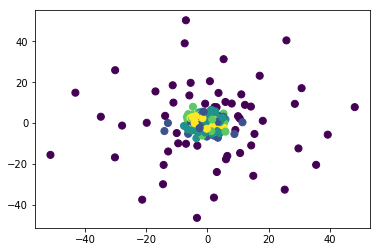

In [19]:
# do not change this plotting function!
def scatter(data, labels, numPoints = 300):

    numEntries = data.shape[0]
    start = np.random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data.iloc[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

# your code goes here
scatter(data,labels)

#### Clustering with DBSCAN

Recall that for DBSCAN, we need to select an Eps and a MinPts. If we choose MinPts to be 4, then Eps can be selected by plotting the distance of every point to its 4th nearest neighbor and finding the "bend" in the graph. 

Q3. Find the optimal Eps for this dataset by plotting the distances of every point to its 4th nearest neighbor.
* Use `sklearn.neighbors.NearestNeighbors` with `n_neighbors=4`. Call `fit` on your data.
* Use the `kneighbors` method to find the distance of each point to its 4th nearest neighbor. Note that `kneighbors` returns two values. The first return value is a matrix of distances from each point to its k nearest neighbors. For example: 

Sklearn considers the distance from the point to itself as the closest neighbor (a distance of 0), then if the point is a distance of 2.5 away from its second nearest neighbor, a distance of 3.7 away from its third nearest neighbor, and a distance of 4.2 away from its fourth nearest neighbor, the row in the distance matrix for this point would look like: `[0, 2.5, 3.7, 4.2]`, indicating that 4.2 is the distance from this point to it's 4th nearest neighbor. 

* Plot the distance of every point to its 4th nearest neighbor. Be sure to sort the distances before you plot them. You can use `plt.plot(distances)` then `plt.show()` to plot them. 
* Use the plot to determine the best Eps for this dataset (just eyeball it).

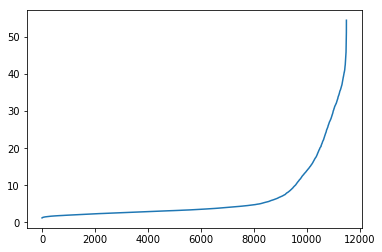

In [5]:
# your code goes here
distances = []
nn = NearestNeighbors(n_neighbors=4)
nn.fit(data)
dist, ind = nn.kneighbors()
for distance in dist:
    distance.sort()
    distances.append(distance[3])
distances.sort()
plt.plot(distances)
plt.show()
# Eps = 10

Q4. 
* Using MinPts=4 and Eps=the distance you determined from Q4, cluster the data using `sklearn.cluster.DBSCAN`. Call `fit_predict` on your data and store the return value (the predicted cluster label for each data point). Note that the returned type is a numpy array. 
* Use the provided `scatter` function (Q2) to plot the resulting clusters. You will need to convert the numpy array of predicted labels to a `Series` in order to pass it in to `scatter`.

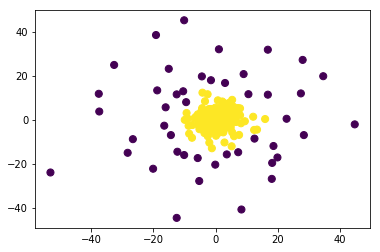

In [87]:
# your code goes here
clustering = DBSCAN(eps=10, min_samples=4).fit_predict(data)
clustering = pd.Series(clustering)
scatter(data,clustering)

#### Clustering with K-means

Q5. 
* Use `sklearn.cluster.KMeans` to cluster this data using K means. Try values of k from 2 to 5. You will need to call `fit_predict` on your data and store the return value (the predicted cluster label for each data point). Note that the returned type is a numpy array. 
* Use `sklearn.metrics.silhouette_score` to evaluate which is the best number of clusters for this dataset. Note that you will need to cast the numpy array to a Series in order to pass it in to `silhouette_score`.
* Use the provided `scatter` function (Q2) to plot the clustering that resulted in the best shilhouette score.

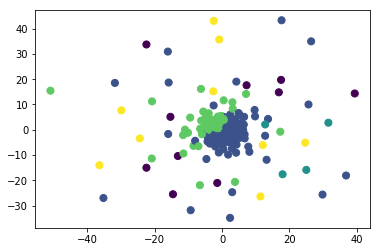

In [27]:
# your code goes here
bestSilhouette_score = -1
bestK = 0
for i in list(range(2,6)):
    cluster = KMeans(n_clusters=i).fit_predict(data)
    cluster = pd.Series(cluster)
    silhouette = silhouette_score(data, cluster)
    if silhouette > bestSilhouette_score:
        bestK = i
cluster = KMeans(n_clusters=bestK).fit_predict(data)
cluster = pd.Series(cluster)
scatter(data,cluster)

Q6. What do you observe about the results of DBSCAN vs the results of K-means? Answer as a comment.

In [ ]:
'''
Your answer goes here.
K-means tends to dismiss about cohesion it is trying to choose from 
the peak silhouette coefficient careless that the gain is not increasing much.
On the other side, DBSCAN defines a minimum cohesion points and an epsilon indicating
separation, it can be inferred that the algorithm is choosing a center cluster and
definning the rest as noise.
'''

#### Hierarchical Clustering

For hierarchical clustering (Q7 and Q8), you'll work with just a sample of 115 datapoints. The function to downsample your data is provided here for you.

In [5]:
# Do not change the code in this cell
# stratified sampling of the data
def downsample_data(data):
    downData = None
    downLabels = None

    kfold = StratifiedKFold(n_splits = 100, shuffle = True)
    for throwAway_index, subsample_index in kfold.split(data, labels):
        downData = data.iloc[subsample_index]
        downLabels = labels.iloc[subsample_index]
        break
    
    print(downData.shape)
    return downData

Q7. Use Scipy's hierarchical clustering (`scipy.cluster.hierarchy`) to cluster the data using different linkage methods. **Make sure you are using a down-sampled dataset by passing your dataset into the provided downsample_data() function.**

* Try all of these linkage methods: `single`, `complete`, `average`, `centroid`, `ward`
* Note that the return value of the clustering is a linkage matrix (a cophenetic distance matrix)

* Calculate the CPCC of each linkage method to determine which method worked best. Use `scipy.cluster.hierarchy.cophenet` for this. You'll pass in the linkage matrix from the clustering, and a proximity matrix that contains the actual distances between each point, which you can get by using `scipy.spatial.distance.pdist`. 

In [15]:
data_hierarchy = downsample_data(data)
methods = ["single","complete","average","centroid","ward"]

# Pass the down-sampled dataset into pdist to get your proximity matrix for calculating CPCC
proximity_matrix = pdist(data_hierarchy)

best_coph = -1
best_method = None

# the rest of your code goes here
for method in methods:
    Z = linkage(data_hierarchy, method)
    coph, coph_matrix = cophenet(Z,proximity_matrix)
    if coph > best_coph:
        best_coph = coph
        best_method = method
        
print(best_method)

(115, 39)
average


Q8. Using the best linkage method that you found in Q7, plot the dendrogram with `scipy.cluster.hierarchy.dendrogram`. 

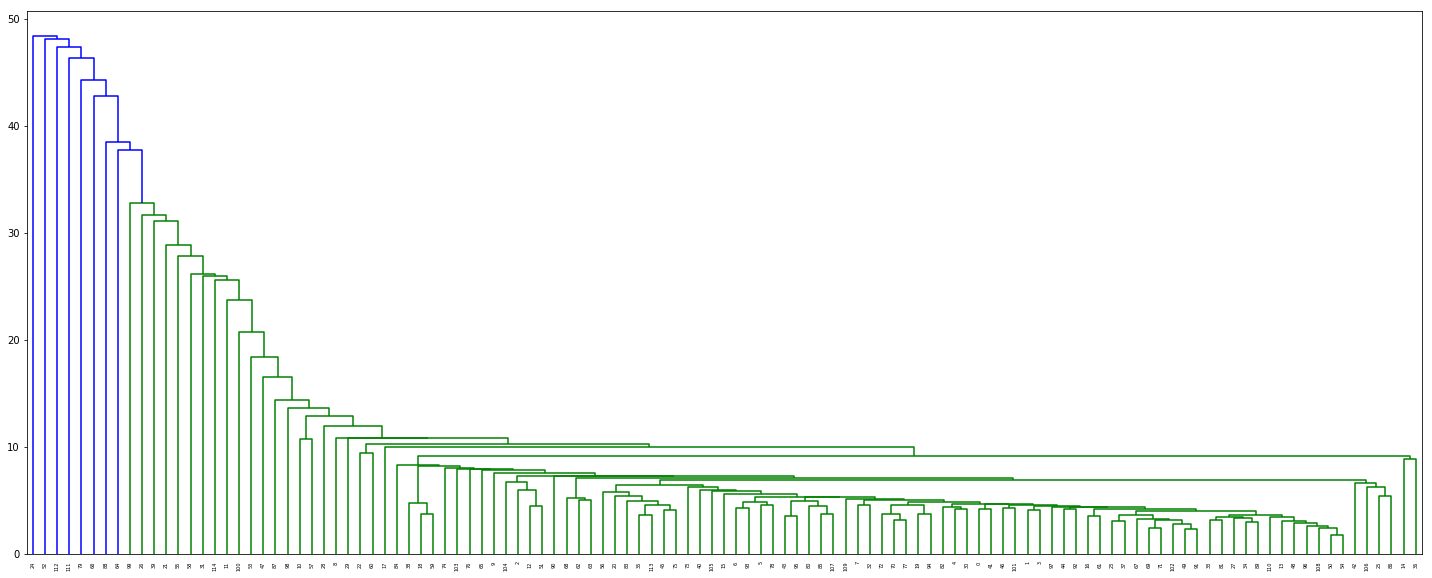

In [18]:
# your code goes here
Z = linkage(data_hierarchy, best_method)
fig = plt.figure(figsize=(25, 10))
dendo = dendrogram(Z)
plt.show()

#### Anomaly Detection (AD)

Anomaly detection (AD) algorithms can be broadly classified into 3 classes (see Nicolas Goix's [slides](https://ngoix.github.io/nicolas_goix_osi_presentation.pdf) on anomaly detection):
- Supervised AD (labels available for both normal data and anomalies)
- Semi-supervised AD, also called Novelty Detection (only normal data is available to train on)
- Unsupervised AD, also called Outlier Detection (no labels are provided)

In this part you'll experiment with 4 datasets and compare 4 different outlier detection (Unsupervised AD) methods.

In [21]:
# loading the datasets
filenames = ['data1.csv', 'data2.csv', 'data3.csv', 'data4.csv']
datasets = [np.loadtxt(fname, delimiter=', ') for fname in filenames]
for fname, data in zip(filenames, datasets):
    print (fname, data.shape)

data1.csv (445, 2)
data2.csv (314, 2)
data3.csv (419, 2)
data4.csv (441, 2)


Q10. Detect the outliers in all 4 datasets using the following algorithms:
- `sklearn.covariance.EllipticEnvelope` - a statistical-based AD method
- `sklearn.ensemble.IsolationForest` - an isolation-based AD method
- `sklearn.neighbors.LocalOutlierFactor` - a density-based AD method
- `sklearn.svm.OneClassSVM` - a model-based AD method

Create scatterplots that show the outliers detected in each dataset with each method. (16 plots in total.)

The following plotting function is provided for you. You should pass in a list of y_pred values corresponding to all 16 of your plots. In order for this plotting function to work correctly, the order of your list should be: ElipticEnvelope on dataset1, ElipticEnvelope on dataset 2, EE on dataset3, EE on dataset4, IsolationForest on dataset1, IsolationForest on ds2, IF on ds3, IF on ds4, LocalOutlierFactor on dataset1, LOF on ds2, LOF on ds3, LOF on ds4, One-Class SVM on dataset1, SVM on ds2, SVM on ds3, SVM on ds4.

In [19]:
# Do not change the code in this cell!
# Create all 16 anomaly detection plots
def plot_all(y_preds):
    
    print("len(y_preds):", len(y_preds))
    
    names = ['Robust Covariance', 'Isolation Forest', 'Local Outlier Factor', 'One-Class SVM']
    plt.figure(figsize=(len(names) * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
    plot_num = 1
    
    for i_dataset in range(len(datasets)):
        for j_algorithm in range(len(names)):
            
            plt.subplot(len(datasets), len(names), plot_num)
            if i_dataset == 0:
                plt.title(names[j_algorithm], size=18)

            colors = np.array(['#377eb8', '#ff7f00'])
            plt.scatter(datasets[i_dataset][:, 0], datasets[i_dataset][:, 1], 
                        s=10, color=colors[(y_preds[plot_num-1] + 1) // 2])

            plt.xlim(-7, 7)
            plt.ylim(-7, 7)
            plt.xticks(())
            plt.yticks(())
            
            plot_num += 1

    plt.show()

Directions:
* Use a `contamination` (or `nu` for `OneClassSVM`) of 0.25.
* For the `OneClassSVM` use `rbf` kernel.
* NOTE: To preform AD in an unsupervised way, you will pass the same dataset into `fit` and `predict.`

Some code is provided here to get you started.

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the d

len(y_preds): 16


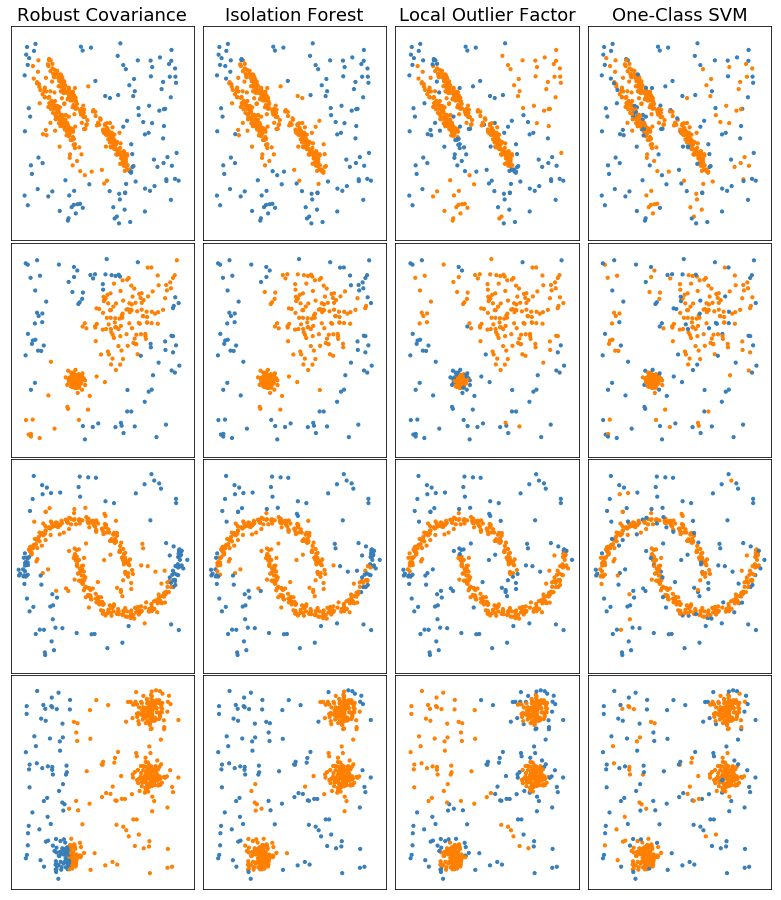

In [24]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


outliers_fraction = 0.25

#this will be your list of 16 plots
y_pred_list = list()

#for each of the 4 datasets
for X in datasets:
    
    #apply EllipticEnvelope AD
    #append resulting y_pred to y_pred_list
    elipt = EllipticEnvelope(contamination=outliers_fraction)
    y_pred = elipt.fit_predict(X)
    y_pred_list.append(y_pred)
    
    #apply IsolationForest AD
    #append resulting y_pred to y_pred_list
    iso = IsolationForest(contamination=outliers_fraction)
    y_pred = iso.fit_predict(X)
    y_pred_list.append(y_pred)
    
    #apply LocalOutlierFactor AD
    #append resulting y_pred to y_pred_list
    loc = LocalOutlierFactor(contamination=outliers_fraction)
    y_pred = loc.fit_predict(X)
    y_pred_list.append(y_pred)

    #apply OneClassSVM AD
    #append resulting y_pred to y_pred_list
    # Default rbf
    oneSVM = OneClassSVM(nu=outliers_fraction, kernel="rbf")
    y_pred = oneSVM.fit_predict(X)
    y_pred_list.append(y_pred)

 

plot_all(y_pred_list)